**Importing the Olivetti Dataset**

In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
data=np.load('/content/drive/My Drive/olivetti_faces.npy')

Mounted at /content/drive


**Creating a set of 200 images from 400 images**

In [ ]:
arr=[]
from numpy import random
for i in range(40):
  narr=np.random.choice(10, 5, replace=False)
  for k in range(5):
    arr.append(data[10*i+narr[k]]); 

**Creating triplet sets**

In [ ]:
positive = []
anchor = []
negative =[]
for i in range(40):
  for j in range(5):
    for k in range(5):
      if (k!=j):
        for l in range(200):
          if (not((5*i<=l) and ((5*i+4)>=l))):
            positive.append(arr[5*i + j])
            anchor.append(arr[5*i + k])
            negative.append(arr[l])

**Shuffling the triplets**

In [ ]:
shuffle=np.random.choice(156000, 156000, replace=False)
final_positive=[]
final_anchor=[]
final_negative=[]
for i in range(156000):
  final_positive.append(positive[shuffle[i]])
  final_anchor.append(anchor[shuffle[i]])
  final_negative.append(negative[shuffle[i]])

**Splitting into test, train and validation data**

In [ ]:
train_p=[]
train_a=[]
train_n=[]
test_p=[]
test_a=[]
test_n=[]
validation_p=[]
validation_a=[]
validation_n=[]
for i in range(117000):
  train_p.append(final_positive[i])
  train_a.append(final_anchor[i])
  train_n.append(final_negative[i])
for i in range(19500):
  test_p.append(final_positive[117000+i])
  test_a.append(final_anchor[117000+i])
  test_n.append(final_negative[117000+i])
for i in range(19500):
  validation_p.append(final_positive[136500+i])
  validation_a.append(final_anchor[136500+i])
  validation_n.append(final_negative[136500+i])

train_p = np.array(train_p)
train_a = np.array(train_a)
train_n = np.array(train_n)
test_p = np.array(test_p)
test_a = np.array(test_a)
test_n = np.array(test_n)
validation_p = np.array(validation_p)
validation_a = np.array(validation_a)
validation_n = np.array(validation_n)

**CNN Model**

In [ ]:
import tensorflow
from tensorflow import keras
from keras import models
from keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D

def MODEL():
  model=Sequential()
  model.add(Conv2D(32, kernel_size=(5, 5), activation='relu',input_shape=(64,64,1)))
  model.add(MaxPooling2D(2))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(2))
  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(2))
  model.add(Flatten())
  model.add(Dense(128, activation='sigmoid'))
  return model

**Feature extraction and Siamese Model training**

In [ ]:
features=MODEL()
positive_train=Input(shape=(64,64,1))
feature_p=features(positive_train)
anchor_train=Input(shape=(64,64,1))
feature_a=features(anchor_train)
negative_train=Input(shape=(64,64,1))
feature_n=features(negative_train)
siamese=models.Model(inputs=[positive_train,anchor_train,negative_train],outputs=[feature_p,feature_a,feature_n])

from keras import backend
loss=((feature_a-feature_p)**2)-((feature_a-feature_n)**2)+0.4
loss=backend.sum(loss,axis=1)
loss=backend.maximum(loss,0)
loss=backend.mean(loss)
siamese.add_loss(loss)
siamese.compile(optimizer='adam')
history=siamese.fit([train_p,train_a,train_n], np.zeros((117000,128)), batch_size=32, epochs=30, validation_data=[validation_p,validation_a,validation_n])

Epoch 1/30
3657/3657 [==============================] - 140s 30ms/step - loss: 18.5223 - val_loss: 5.2040
Epoch 2/30
3657/3657 [==============================] - 109s 30ms/step - loss: 4.6266 - val_loss: 5.6601
Epoch 3/30
3657/3657 [==============================] - 109s 30ms/step - loss: 3.6750 - val_loss: 3.2497
Epoch 4/30
3657/3657 [==============================] - 108s 30ms/step - loss: 3.0335 - val_loss: 2.6793
Epoch 5/30
3657/3657 [==============================] - 109s 30ms/step - loss: 2.6072 - val_loss: 2.2096
Epoch 6/30
3657/3657 [==============================] - 108s 30ms/step - loss: 2.1765 - val_loss: 2.1692
Epoch 7/30
3657/3657 [==============================] - 108s 30ms/step - loss: 2.1759 - val_loss: 2.1655
Epoch 8/30
3657/3657 [==============================] - 108s 30ms/step - loss: 2.1992 - val_loss: 2.0040
Epoch 9/30
3657/3657 [==============================] - 108s 30ms/step - loss: 1.9995 - val_loss: 1.7789
Epoch 10/30
3657/3657 [==============================]

**Plotting loss and val_loss against epochs**

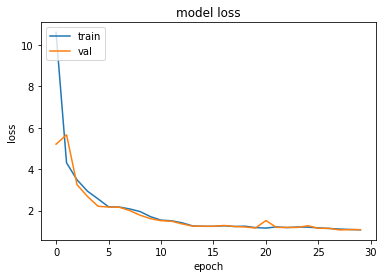

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Accuracy**

In [ ]:
threshold=20
acc=0
n_acc=0

for i in range(19500):
  feature_positive_test=features(test_p[i].reshape(1,64,64,1))
  feature_anchor_test=features(test_a[i].reshape(1,64,64,1))
  feature_negative_test=features(test_n[i].reshape(1,64,64,1))

  AP=backend.sum((feature_anchor_test-feature_positive_test)**2)
  AN=backend.sum((feature_anchor_test-feature_negative_test)**2)

  if (AP)<threshold:
    acc+=1
  else:
    n_acc+=1
  if (AN)>threshold:
    acc+=1
  else:
    n_acc+=1

accuracy=acc*100/(n_acc+acc)
print(accuracy)

99.95384615384616


**Face Detection**

Total faces detected = 28


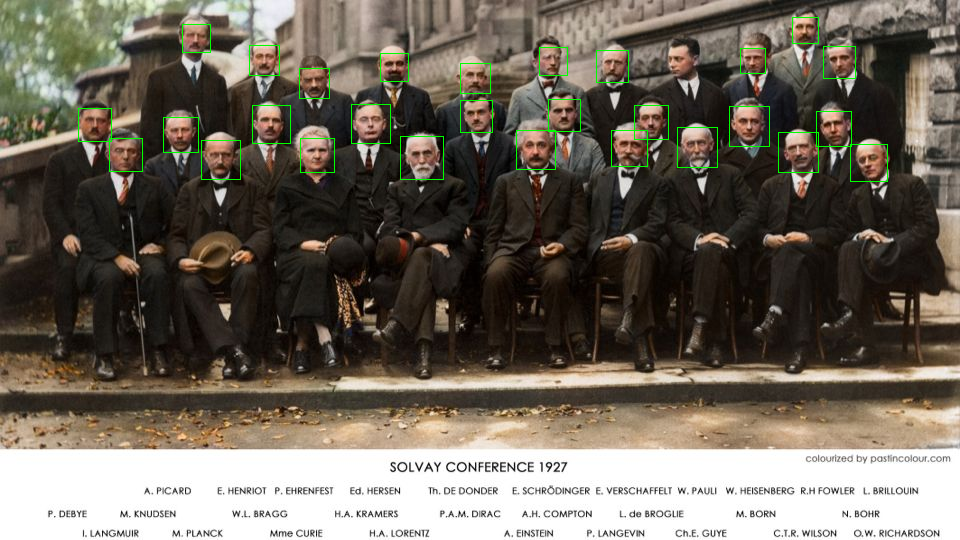

In [ ]:
import cv2
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')
img=cv2.imread('/content/drive/My Drive/scientists.jpg')
grayimg=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(grayimg,1.1)
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),1)
from google.colab.patches import cv2_imshow
print("Total faces detected = "+str(len(faces)))
cv2_imshow(img)